# Evaluation using the BeFree corpus 

### GAD dataset
To obtain a large benchmark of Gene Disease Associations along with associated sentences from literature, we used the corpus generated by BeFree system based on Genetic Association Database (GAD)



#  ------------------------------------------------------------------------------------------

# imports

In [1]:
import tensorflow as tf
import keras
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras_tqdm import TQDMNotebookCallback
import numpy as np
np.random.seed(1337)
from keras_tqdm import TQDMNotebookCallback
import nltk
import xml.etree.ElementTree as ET
import pandas as pd
import os
import string
from nltk.tokenize import TreebankWordTokenizer
from numpy.random import random_sample
import re
import pickle
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from keras.layers import Embedding, Flatten,LSTM, GRU
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation,  Input, merge,Conv1D,MaxPooling1D,GlobalMaxPooling1D,Convolution1D
from keras import regularizers
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from keras.layers import Concatenate, concatenate
from keras import backend as K
from keras.layers import multiply
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
random_seed=1337

Using TensorFlow backend.


###  Define Callback functions to generate Measures

In [2]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Experiments to reproduce the results of Table 7 

### Evaluation results for multi-class classification

### Load Prerocssed Data

In [3]:
with open('../data/pickles/befree_3class_crawl-300d-2M.pickle', 'rb') as handle:
    gene_id_list = pickle.load(handle)
    gene_symbol_list = pickle.load(handle)
    disease_id_list = pickle.load(handle)    
    X_train = pickle.load(handle)
    distance1_vectors = pickle.load(handle)
    distance2_vectors = pickle.load(handle)
    Y_train = pickle.load(handle)
    word_list = pickle.load(handle)
    word_vectors = pickle.load(handle)
    word_dict = pickle.load(handle)
    distance1_dict = pickle.load(handle)
    distance2_dict = pickle.load(handle)
    label_dict = pickle.load(handle)
    MAX_SEQUENCE_LENGTH = pickle.load(handle)
print ("word_vectors",len(word_vectors))

word_vectors 6766


### Create Position Embedding Vectors

In [4]:
import keras
from keras_pos_embd import TrigPosEmbedding

model = keras.models.Sequential()
model.add(TrigPosEmbedding(
    input_shape=(None,),
    output_dim=20,                      # The dimension of embeddings.
    mode=TrigPosEmbedding.MODE_EXPAND,  # Use `expand` mode
    name='Pos-Embd',
))
model.compile('adam', keras.losses.mae, {})


d1_train_embedded=model.predict(distance1_vectors)

d1_train_embedded.shape

d2_train_embedded=model.predict(distance2_vectors)

d2_train_embedded.shape

(5330, 81, 20)

### Prepare Word Embedding Layer

In [5]:
EMBEDDING_DIM=word_vectors.shape[1]
print("EMBEDDING_DIM=",EMBEDDING_DIM)
embedding_matrix=word_vectors

def create_embedding_layer(l2_reg=0.01,use_pretrained=True,is_trainable=False):
    
    if use_pretrained:        
        return Embedding(len(word_dict) ,EMBEDDING_DIM,weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=is_trainable,embeddings_regularizer=regularizers.l2(l2_reg))
    
    else:    
        return Embedding(len(word_dict) ,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH)
            
    

EMBEDDING_DIM= 300


### Prepare Attention Mechanism

In [6]:
INPUT_DIM = 2
TIME_STEPS = MAX_SEQUENCE_LENGTH
def attentionNew(inputs):
    inputs = Lambda(lambda x: tf.keras.backend.tanh(x))(inputs)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Dense(TIME_STEPS, activation='softmax')(a)
    a_probs = Permute((2, 1))(a)
    output_attention_mul = multiply([inputs, a_probs])
    output_attention_mul = Lambda(lambda x: tf.keras.backend.tanh(x))(output_attention_mul)
    return output_attention_mul


### Create the Model

In [7]:
# set parameter for metric calculation, 'macro' for multiclass classification
param='macro' 
def build_model():    

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_layer=create_embedding_layer(use_pretrained=True,is_trainable=False)
    embedded_sequences = embedding_layer(sequence_input)

    
    pos_embedd_1=Input(shape=(MAX_SEQUENCE_LENGTH,20), dtype='float32')
    pos_embedd_2=Input(shape=(MAX_SEQUENCE_LENGTH,20), dtype='float32')
    
    embedded_sequences = concatenate([embedded_sequences,pos_embedd_1,pos_embedd_2])
        
    
    x = Conv1D(32, 5, activation='relu')(embedded_sequences)
    x = MaxPooling1D(3)(x)
    x = Dropout(0.1)(x)
    conv_sequence_w5=GlobalMaxPooling1D()(x)    #x = Flatten()(x)


        
    x = Conv1D(64, 3, activation='relu')(embedded_sequences)
    x = MaxPooling1D(3)(x)
    x = Dropout(0.1)(x)
    conv_sequence_w4=GlobalMaxPooling1D()(x)    #x = Flatten()(x)


            
    x = Conv1D(128, 3, activation='relu')(embedded_sequences)
    x = MaxPooling1D(3)(x)
    x = Dropout(0.1)(x)
    conv_sequence_w3=GlobalMaxPooling1D()(x)    #x = Flatten()(x)

    forward = GRU(100, recurrent_dropout=0.05,return_sequences=True)(embedded_sequences)
    backward = GRU(100, go_backwards=True,recurrent_dropout=0.05,return_sequences=True)(embedded_sequences)
    attention_forward=attentionNew(forward)
    attention_backward=attentionNew(backward)
    lstm_sequence = concatenate([attention_forward,attention_backward])
   
    lstm_sequence = Flatten()(lstm_sequence)
    merge = concatenate([conv_sequence_w5,conv_sequence_w4,conv_sequence_w3,lstm_sequence])
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.1))(merge)
    x = Dropout(0.1)(x)
    preds = Dense(3, activation='softmax')(x)
    model = Model(inputs=[sequence_input, pos_embedd_1,pos_embedd_2],outputs=preds)
    opt=tf.keras.optimizers.Adam()
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['acc',f1])
    return model
    

In [8]:
model = build_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 81)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 81, 300)      2029800     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 81, 20)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 81, 20)       0                                            
____________________________________________________________________________________________

In [9]:
validation_split_rate = 0.1
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
Y = [np.argmax(y, axis=None, out=None) for y in Y_train]
for tr_index, te_index in skf.split(X_train,Y):
    test_index = te_index 
    train_index = tr_index
    
trainRate = (len(train_index)/len(Y))*100   
testRate = (len(test_index)/len(Y))*100   
print ("TrainRate:{:.2f}% testRate:{:.2f}% validation:{:.2f}%  ".format(trainRate,testRate, trainRate*validation_split_rate))
X_train, X_test = X_train[train_index], X_train[test_index] 
pos_train1, pos_test1 = d1_train_embedded[train_index], d1_train_embedded[test_index] 
pos_train2, pos_test2 = d2_train_embedded[train_index], d2_train_embedded[test_index] 
y_train, y_test = Y_train[train_index], Y_train[test_index]



# # Saving the training data split as a pickle file
# training_data = {
#     'X_train': X_train,
#     'pos_train1': pos_train1,
#     'pos_train2': pos_train2,
#     'y_train': y_train
# }

# with open('training_data12.pkl', 'wb') as f:
#     pickle.dump(training_data, f)

# # Saving the testing data split as a pickle file
# testing_data = {
#     'X_test': X_test,
#     'pos_test1': pos_test1,
#     'pos_test2': pos_test2,
#     'y_test': y_test
# }

# with open('testing_data12.pkl', 'wb') as f:
#     pickle.dump(testing_data, f)
    



TrainRate:80.00% testRate:20.00% validation:8.00%  


In [10]:
# Load the training data from the pickle file
with open('training_data.pkl', 'rb') as f:
    train_data = pickle.load(f)

# Load the testing data from the pickle file
with open('testing_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

# Extract data from the loaded dictionaries
X_train = train_data['X_train']
pos_train1 = train_data['pos_train1']
pos_train2 = train_data['pos_train2']
y_train = train_data['y_train']


X_test = test_data['X_test']
pos_test1 = test_data['pos_test1']
pos_test2 = test_data['pos_test2']
y_test = test_data['y_test']
print(X_train.shape)
print(X_test.shape)

(4264, 81)
(1066, 81)


### Run the Evaluation using 10 fold Cross Validation  

In [11]:
MaxEpochs =50
batchsize =32
validation_split_rate = 0.1
history=model.fit([X_train,pos_train1,pos_train2], y_train,validation_split=validation_split_rate ,epochs=MaxEpochs, batch_size=batchsize,verbose=1)



 

Train on 3837 samples, validate on 427 samples
Epoch 1/50
3837/3837 [==============================] - 87s 23ms/step - loss: 2780.3121 - acc: 0.4454 - f1: 0.1384 - val_loss: 2779.7211 - val_acc: 0.4333 - val_f1: 0.0397
Epoch 2/50
3837/3837 [==============================] - 21s 5ms/step - loss: 2779.6360 - acc: 0.4699 - f1: 0.1608 - val_loss: 2779.6530 - val_acc: 0.4333 - val_f1: 0.1856
Epoch 3/50
3837/3837 [==============================] - 21s 5ms/step - loss: 2779.5958 - acc: 0.4788 - f1: 0.2140 - val_loss: 2779.6675 - val_acc: 0.4450 - val_f1: 0.0709
Epoch 4/50
3837/3837 [==============================] - 21s 5ms/step - loss: 2779.5398 - acc: 0.4827 - f1: 0.2854 - val_loss: 2779.7274 - val_acc: 0.5012 - val_f1: 0.3381
Epoch 5/50
3837/3837 [==============================] - 21s 5ms/step - loss: 2779.4688 - acc: 0.5442 - f1: 0.4584 - val_loss: 2779.6347 - val_acc: 0.4567 - val_f1: 0.4231
Epoch 6/50
3837/3837 [==============================] - 21s 5ms/step - loss: 2779.4364 - acc: 0.5

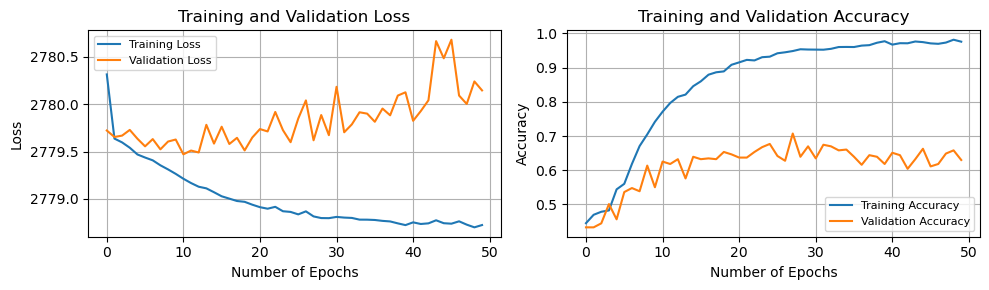

In [12]:
import matplotlib.pyplot as plt

# Training & Validation accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = len(train_loss)

xc = range(epochs)

plt.figure(figsize=(10, 3))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(xc, train_loss, label='Training Loss')
plt.plot(xc, val_loss, label='Validation Loss')
plt.xlabel('Number of Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Training and Validation Loss', fontsize=12)
plt.legend(fontsize=8)
plt.grid(True)

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(xc, train_acc, label='Training Accuracy')
plt.plot(xc, val_acc, label='Validation Accuracy')
plt.xlabel('Number of Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Training and Validation Accuracy', fontsize=12)
plt.legend(fontsize=8, loc='lower right')  # Change position to lower right
plt.grid(True)

plt.tight_layout()
plt.show()


In [13]:
import torch
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support

# Predict on the training dataset
train_predicted = np.argmax(model.predict([X_train, pos_train1, pos_train2]), axis=1)
y_train_to_label = np.argmax(y_train, axis=1)

# Calculate accuracy, precision, recall, and F1-score for the training data
train_accuracy = accuracy_score(y_train_to_label, train_predicted)
train_prec, train_reca, train_fscore, _ = precision_recall_fscore_support(y_train_to_label, train_predicted, average=param)

# Print the classification report for the training data
print("Training Classification Report:")
print(classification_report(y_train_to_label, train_predicted))

# Print the precision, recall, and F1-score for the training data
print("Training Accuracy: {:.2f}%".format(train_accuracy * 100))
print("Training Precision: {:.2f}%".format(train_prec * 100))
print("Training Recall: {:.2f}%".format(train_reca * 100))
print("Training F1 Score: {:.2f}%".format(train_fscore * 100))


Training Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      2023
           1       0.86      0.95      0.90      1468
           2       0.86      0.77      0.81       773

    accuracy                           0.88      4264
   macro avg       0.88      0.86      0.87      4264
weighted avg       0.88      0.88      0.88      4264

Training Accuracy: 88.20%
Training Precision: 87.62%
Training Recall: 86.41%
Training F1 Score: 86.85%


In [14]:
predicted = np.argmax(model.predict([X_test,pos_test1,pos_test2]), axis=1)
y_test_to_label = np.argmax(y_test, axis=1)
prec, reca, fscore, sup = precision_recall_fscore_support(y_test_to_label, predicted, average=param)
# Generate the classification report as a dictionary
report_dict = classification_report(y_test_to_label, predicted, output_dict=True)

# Create a new dictionary to hold the formatted values
formatted_report_dict = {}

# Iterate over the items in the report dictionary
for key, value in report_dict.items():
    if isinstance(value, dict):
        # Format the nested dictionary values
        formatted_report_dict[key] = {sub_key: f"{sub_value:.4f}" for sub_key, sub_value in value.items()}
    else:
        # Format the top-level dictionary values
        formatted_report_dict[key] = f"{value:.4f}"

# Create a string representation of the formatted dictionary
formatted_report_str = classification_report(y_test_to_label, predicted, digits=4)

# Print the formatted classification report
print(formatted_report_str)
print(" Precision:{:.2f}% Recall:{:.2f}% Fscore:{:.2f}% ".format(prec*100, reca*100, fscore*100))

              precision    recall  f1-score   support

           0     0.7795    0.7689    0.7742       515
           1     0.7473    0.8216    0.7827       342
           2     0.7637    0.6651    0.7110       209

    accuracy                         0.7655      1066
   macro avg     0.7635    0.7519    0.7560      1066
weighted avg     0.7661    0.7655    0.7645      1066

 Precision:76.35% Recall:75.19% Fscore:75.60% 


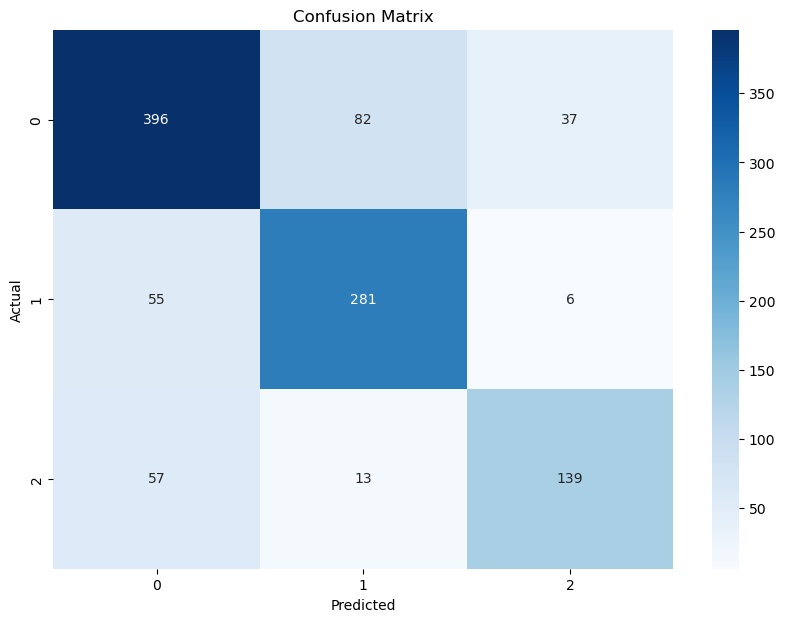

 Precision:76.35% Recall:75.19% Fscore:75.60% 


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
# Calculate and visualize the confusion matrix
cm = confusion_matrix(y_test_to_label, predicted)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1','2'], yticklabels=['0', '1','2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print precision, recall, and f-score
prec, reca, fscore, sup = precision_recall_fscore_support(y_test_to_label, predicted, average=param)
print(" Precision:{:.2f}% Recall:{:.2f}% Fscore:{:.2f}% ".format(prec*100, reca*100, fscore*100))